<a href="https://colab.research.google.com/github/esuda/mineiracao_dados_complexos/blob/master/INF0618_Trabalho_01_Kurosawa_Suda_Wakabayashi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Inf0618 Deep Learning - Trabalho 1 - CNN**
## Integrantes do grupo:
#### - Daniel Noriaki Kurosawa
#### - Eric Uyemura Suda
#### - Fernando Shigeru Wakabayashi

In [120]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Oct 31 00:05:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    33W / 250W |   4645MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [121]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0-beta1

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
#Importando as libs necessarias


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, Dense, Flatten, Dropout,
    GlobalMaxPooling2D, MaxPooling2D, BatchNormalization, MaxPool2D
)

from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


from sklearn.metrics import (
    confusion_matrix, classification_report,
    balanced_accuracy_score
)
np.set_printoptions(precision=4,suppress=True)

%matplotlib inline

In [126]:
#Importando Dataset do trabalho

from tensorflow.keras.datasets import cifar10
(x_trainval, y_trainval), (x_test, y_test) = cifar10.load_data()

In [127]:
#Cada imagem tem o tamanho de 32x32x3

print("Tamanho treino {}".format(x_trainval.shape), "\t", "Tamanho teste {}".format(x_test.shape))

Tamanho treino (50000, 32, 32, 3) 	 Tamanho teste (10000, 32, 32, 3)


In [128]:
#Dataset ja esta balanceado com 5k amostras para cada classe de imagem

unique, counts = np.unique(y_trainval, return_counts=True)
print("Treino ---> ", dict(zip(unique, counts)), "\n")

Treino --->  {0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000} 



# 1) Separando Dataset em Treino e Validacao (0,5)

Separe 20% dos dados de treinamento para validação. Todos os treinamentos intermediários devem ser avaliados neste conjunto de validação.



In [129]:
#Embaralha os dados e divide em 80% para treino, 20% para validação
nData = x_trainval.shape[0]  
nTrain = int(nData * 0.8)  
randomIdx = np.random.permutation(np.arange(nData))
trainIdx = randomIdx[:nTrain] 
valIdx = randomIdx[nTrain:]

#Divide os dados
x_val, y_val = x_trainval[valIdx], y_trainval[valIdx]
x_train, y_train = x_trainval[trainIdx], y_trainval[trainIdx]

print("Formato das imagens de treinamento", x_train.shape)
print("Formato dos rótulos de treinamento", y_train.shape)
print()

print("Formato das imagens de validação", x_val.shape)
print("Formato dos rótulos de validação", y_val.shape)

Formato das imagens de treinamento (40000, 32, 32, 3)
Formato dos rótulos de treinamento (40000, 1)

Formato das imagens de validação (10000, 32, 32, 3)
Formato dos rótulos de validação (10000, 1)


Escalando dados de para um intervalo de 0-1

In [130]:
x_train = x_train / 255.0
x_val = x_val / 255.0
x_test = x_test / 255.0

Pré Processando Saídas

In [131]:
#Para utilizar SparceCategoricalCrossentropy
y_train_f,  y_val_f, y_test_f = y_train.flatten(), y_val.flatten(), y_test.flatten()
#teste de sanidade
pd.Series(y_train_f).value_counts().sort_index()

0    3961
1    3981
2    4004
3    3996
4    4034
5    4016
6    4020
7    4006
8    4002
9    3980
dtype: int64

In [132]:
# One hot encoding das classes de saida
num_classes = len(np.unique(y_train))
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_oh = tf.keras.utils.to_categorical(y_val, num_classes)
y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes)
print(x_train.shape, y_train_oh.shape)
print("Exemplo: ")
print("Classe Imagem: ", y_train[0], "\tOne Hot: ", y_train_oh[0])

(40000, 32, 32, 3) (40000, 10)
Exemplo: 
Classe Imagem:  [3] 	One Hot:  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [133]:
num_classes

10

# 2) Criando Rede Neural Baseline (1,0)

Construa uma rede neural convolucional para baseline. Sugestão: comece por uma arquitetura simples. Quanto mais simples, melhor.

Função para printar Confusion matrix e gráficos de Loss e Acc

In [119]:
def print_evaluate(model, model_history , x_val, y_val_model, model_filepath):
    print("\nFazendo Predicoes da Validacao\n")
    model.load_weights(model_filepath)
    predictions = model.predict(x_val)
    #score = model.evaluate(x_test, y_test_oh, verbose=1) # Poderia ser usado se o objetivo é ter apenas a métrica.
    
    #Matriz de confusão
    cm = confusion_matrix(np.argmax(predictions, axis=1), y_val)


    cm_b = cm / cm.astype(np.float).sum(axis=1, keepdims=True)
    balanced_acc = np.trace(cm_b) / num_classes
    print("\n\nAcurácia balanceada:", balanced_acc, "\n")

    fig, axs = plt.subplots(2, 2, figsize = (16,12), gridspec_kw={'height_ratios': [2, 1]})

    #ax[0,0]
    sns.heatmap(ax = axs[0, 0], data = cm, fmt='g', annot = True)
    axs[0, 0].set_title('Matriz de Confusao')
    #ax[0,1]
    sns.heatmap(ax = axs[0, 1], data =cm_b, fmt='.1%', annot = True)
    axs[0, 1].set_title('Matriz de Confusao Normalizada')

    #ax[1,0]
    axs[1, 0].set_title('Loss')
    axs[1, 0].plot(model_history.history['loss'], label='loss')
    axs[1, 0].plot(model_history.history['val_loss'], label='val_loss')
    axs[1, 0].legend()

    axs[1, 1].set_title('accuracy')
    axs[1, 1].plot(model_history.history['accuracy'], label='acc')
    axs[1, 1].plot(model_history.history['val_accuracy'], label='val_acc')
    axs[1, 1].legend()  


### 2.1) Teste com CategoricalCrossentropy

In [92]:
# Rede Neural Vanilla
model_baseline = Sequential()
#Camada convolucional com 32 filtros de tamanho 3x3 
model_baseline.add(Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3)))
#Max pooling de tamanho 2x2
model_baseline.add(MaxPooling2D(pool_size=(2,2)))
#Operação de vetorização dos dados
model_baseline.add(Flatten())
#Densa com 10 nós de saída
model_baseline.add(Dense(10,activation='softmax'))

model_baseline.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

model_baseline.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 10)                81930     
Total params: 82,826
Trainable params: 82,826
Non-trainable params: 0
_________________________________________________________________


In [93]:
filepath="model_baseline_hist.h5"
early_stop = EarlyStopping(monitor='val_loss',patience=20)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#.fit(x_train,y_cat_train,epochs=15,validation_data=(x_test,y_cat_test),callbacks=[early_stop])
model_baseline_hist = model_baseline.fit(x_train, y_train_oh,
                                         epochs = 64, batch_size = 32,                                        
                                         validation_data=(x_val, y_val_oh),
                                         callbacks=[early_stop, checkpoint] )

Epoch 1/64
1250/1250 [==============================] - 4s 3ms/step - loss: 1.8353 - accuracy: 0.3400 - val_loss: 1.7588 - val_accuracy: 0.3833

Epoch 00001: val_accuracy improved from -inf to 0.38330, saving model to model_baseline_hist.h5
Epoch 2/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.6769 - accuracy: 0.4027 - val_loss: 1.7111 - val_accuracy: 0.3870

Epoch 00002: val_accuracy improved from 0.38330 to 0.38700, saving model to model_baseline_hist.h5
Epoch 3/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.6287 - accuracy: 0.4255 - val_loss: 1.6280 - val_accuracy: 0.4297

Epoch 00003: val_accuracy improved from 0.38700 to 0.42970, saving model to model_baseline_hist.h5
Epoch 4/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.6095 - accuracy: 0.4310 - val_loss: 1.6139 - val_accuracy: 0.4362

Epoch 00004: val_accuracy improved from 0.42970 to 0.43620, saving model to model_baseline_hist.h5
Epoch 5/64
1250/1250 [=====


Fazendo Predicoes da Validacao



Acurácia balanceada: 0.45425584617191594 



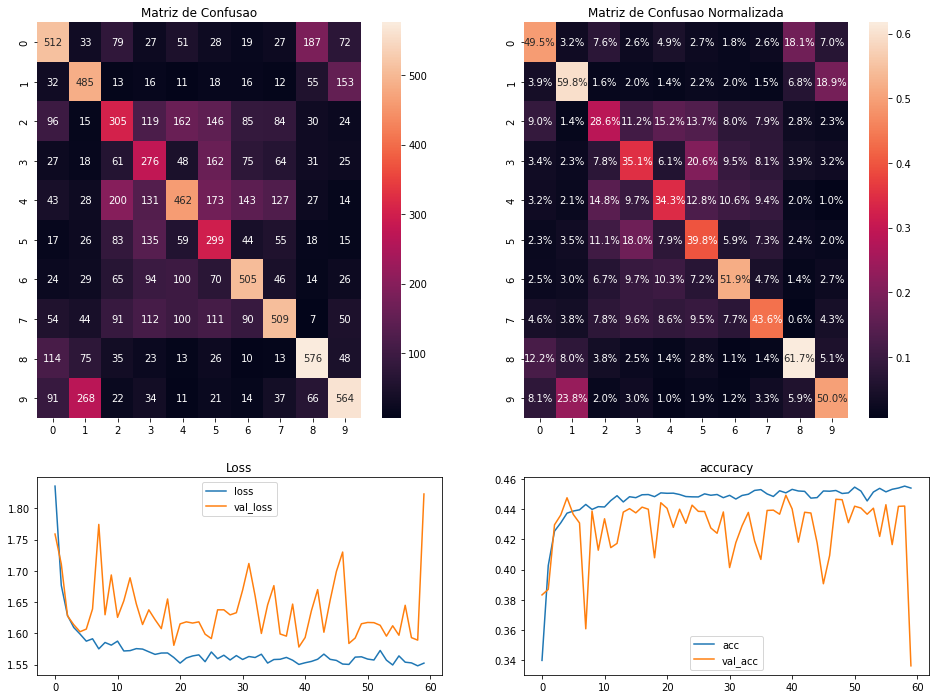

In [94]:
print_evaluate(model_baseline,model_baseline_hist, x_val, y_val_oh,"model_baseline_hist.h5" )

### 2.2 ) Teste com SparseCategoricalCrossentropy

In [95]:
# Rede Neural Vanilla

model_baseline = tf.keras.Sequential()
#Camada convolucional com 32 filtros de tamanho 3x3 e ativação ReLU
model_baseline.add(Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3)))
#Max pooling de tamanho 2x2
model_baseline.add(MaxPooling2D(pool_size=(2,2)))
#Operação de vetorização dos dados
model_baseline.add(Flatten())
#Densa com 10 nós de saída
model_baseline.add(Dense(10 ,activation = 'softmax'))

model_baseline.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model_baseline.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_27 (Dense)             (None, 10)                81930     
Total params: 82,826
Trainable params: 82,826
Non-trainable params: 0
_________________________________________________________________


In [96]:
filepath="model_baseline_hist_cce.h5"
early_stop = EarlyStopping(monitor='val_loss',patience=20)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


model_baseline_hist = model_baseline.fit(x_train, y_train_f,
                                         epochs = 64, batch_size = 32,                                        
                                         validation_data=(x_val, y_val_f),
                                         callbacks=[early_stop, checkpoint] )


Epoch 1/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.8961 - accuracy: 0.3323 - val_loss: 1.8414 - val_accuracy: 0.3618

Epoch 00001: val_accuracy improved from -inf to 0.36180, saving model to model_baseline_hist_cce.h5
Epoch 2/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.7822 - accuracy: 0.3688 - val_loss: 1.8024 - val_accuracy: 0.3666

Epoch 00002: val_accuracy improved from 0.36180 to 0.36660, saving model to model_baseline_hist_cce.h5
Epoch 3/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.7737 - accuracy: 0.3731 - val_loss: 1.8263 - val_accuracy: 0.3545

Epoch 00003: val_accuracy did not improve from 0.36660
Epoch 4/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.7682 - accuracy: 0.3771 - val_loss: 1.8717 - val_accuracy: 0.3230

Epoch 00004: val_accuracy did not improve from 0.36660
Epoch 5/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.7677 - accuracy: 0.3754 - val


Fazendo Predicoes da Validacao



Acurácia balanceada: 0.38883188650262945 



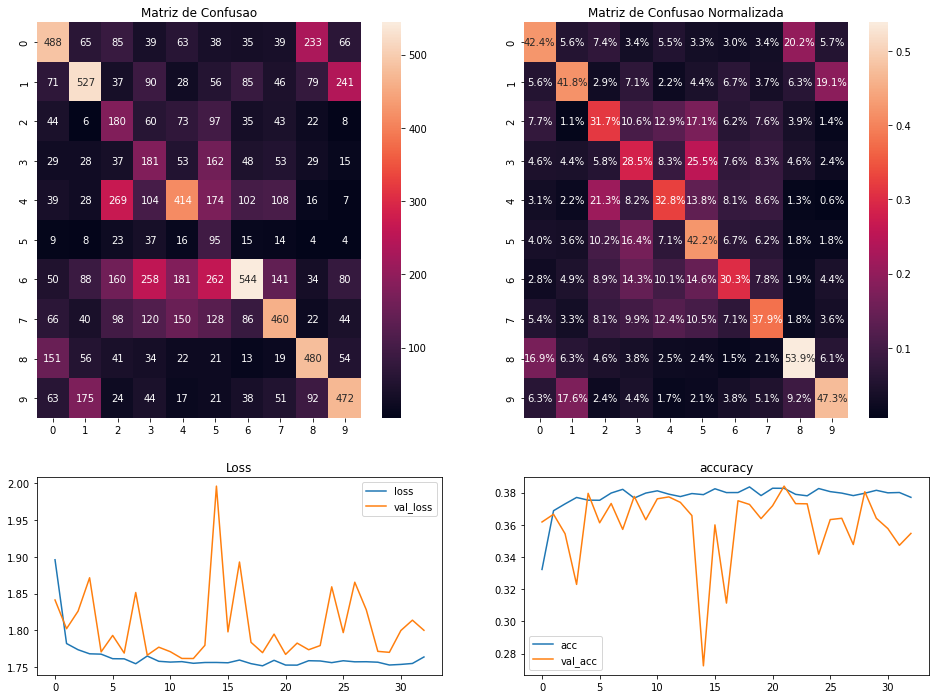

In [97]:
print_evaluate(model_baseline,model_baseline_hist, x_val, y_val_f, 'model_baseline_hist_cce.h5')

Observando a acurácia decidimos por utilizar a SparseCategoricalCrossentropy(), a Loss do Sparce aparenta começo de overfitting, aumentanto / se mantendo estável enquanto a loss de treino diminui, porém ele apresenta melhor acc na acurácia, outro ponto de vista é que no gráfico de  não da pra verificar regiões de overffiting 

# 3) Testando Diferentes Funcoes de Ativacao Para o Mesmo Modelo Baseline (0,5)

[Referencia de Funcoes de Ativacao](https://keras.io/api/layers/activations/)

 Explore o impacto de três diferentes funções de ativação.


In [98]:
def ret_model_vanila(activation:str = 'relu')->Sequential:
  model = Sequential()
  #Camada convolucional com 32 filtros de tamanho 3x3 
  model.add(Conv2D(32, 3, padding='same', activation=activation, input_shape=(32, 32, 3)))
  #Max pooling de tamanho 2x2
  model.add(MaxPooling2D(pool_size=(2,2)))
  #Operação de vetorização dos dados
  model.add(Flatten())
  #Densa com 10 nós de saída
  model.add(Dense(10, activation='softmax'))

  model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])

  model.summary()
  return model



3.1 - Sigmoid

In [99]:
# Modelo Vanilla com Funcao de Ativacao Sigmoide
model_baseline_sig =ret_model_vanila(activation='sigmoid')

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 10)                81930     
Total params: 82,826
Trainable params: 82,826
Non-trainable params: 0
_________________________________________________________________


In [100]:
filepath="model_baseline_sig.h5"
early_stop = EarlyStopping(monitor='val_loss',patience=20)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


history_model_baseline_sig = model_baseline_sig.fit(x_train, y_train_f,
                                            epochs = 64, batch_size = 32,                                        
                                            validation_data=(x_val, y_val_f),
                                            callbacks=[early_stop, checkpoint] )


Epoch 1/64
1250/1250 [==============================] - 3s 2ms/step - loss: 2.5222 - accuracy: 0.2839 - val_loss: 1.8821 - val_accuracy: 0.3491

Epoch 00001: val_accuracy improved from -inf to 0.34910, saving model to model_baseline_sig.h5
Epoch 2/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.7616 - accuracy: 0.3893 - val_loss: 1.6479 - val_accuracy: 0.4219

Epoch 00002: val_accuracy improved from 0.34910 to 0.42190, saving model to model_baseline_sig.h5
Epoch 3/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.5537 - accuracy: 0.4571 - val_loss: 1.5158 - val_accuracy: 0.4675

Epoch 00003: val_accuracy improved from 0.42190 to 0.46750, saving model to model_baseline_sig.h5
Epoch 4/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.4567 - accuracy: 0.4944 - val_loss: 1.4831 - val_accuracy: 0.4854

Epoch 00004: val_accuracy improved from 0.46750 to 0.48540, saving model to model_baseline_sig.h5
Epoch 5/64
1250/1250 [=========


Fazendo Predicoes da Validacao



Acurácia balanceada: 0.5702288671824541 



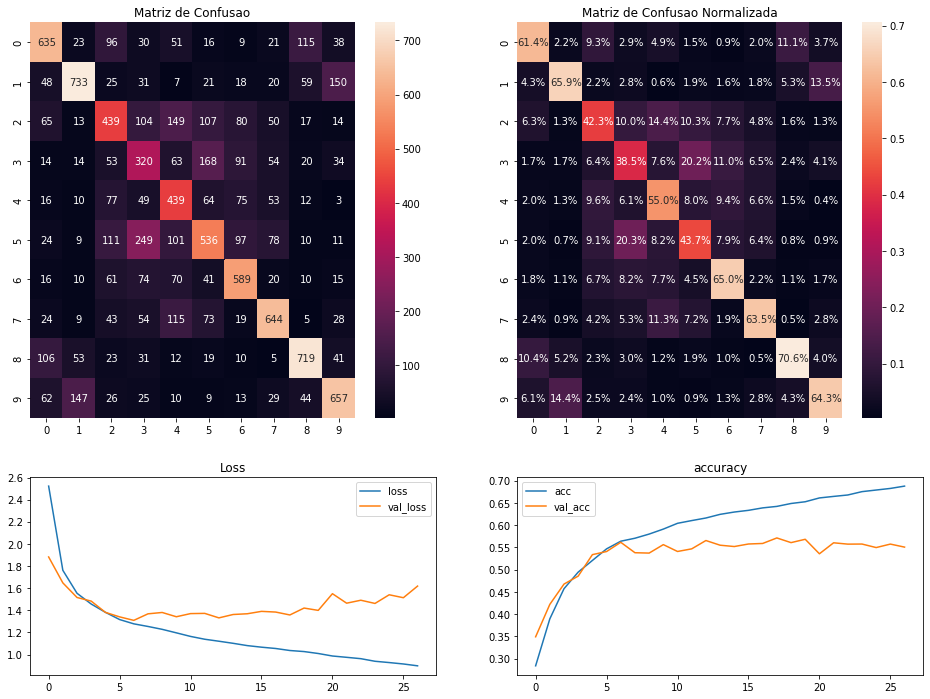

In [101]:
print_evaluate(model_baseline_sig, history_model_baseline_sig, x_val, y_val_f, 'model_baseline_sig.h5')

3.2 - Tangente Hiperbólica

In [102]:
# Modelo Vanilla com Funcao de Ativacao Tangente Hiperbolica
model_baseline_tan = ret_model_vanila(activation='tanh')

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_29 (Dense)             (None, 10)                81930     
Total params: 82,826
Trainable params: 82,826
Non-trainable params: 0
_________________________________________________________________


In [103]:
filepath="model_tan.h5"
early_stop = EarlyStopping(monitor='val_loss',patience=20)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


history_model_baseline_tan = model_baseline_tan.fit(x_train, y_train_f,
                                                    epochs = 64, batch_size = 32,                                        
                                                    validation_data=(x_val, y_val_f),
                                                    callbacks=[early_stop, checkpoint] )

Epoch 1/64
1250/1250 [==============================] - 3s 2ms/step - loss: 2.2304 - accuracy: 0.3804 - val_loss: 1.7175 - val_accuracy: 0.4635

Epoch 00001: val_accuracy improved from -inf to 0.46350, saving model to model_tan.h5
Epoch 2/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.6732 - accuracy: 0.4775 - val_loss: 1.9618 - val_accuracy: 0.4445

Epoch 00002: val_accuracy did not improve from 0.46350
Epoch 3/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.7776 - accuracy: 0.4825 - val_loss: 1.6427 - val_accuracy: 0.4974

Epoch 00003: val_accuracy improved from 0.46350 to 0.49740, saving model to model_tan.h5
Epoch 4/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.8638 - accuracy: 0.4992 - val_loss: 2.0018 - val_accuracy: 0.4696

Epoch 00004: val_accuracy did not improve from 0.49740
Epoch 5/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.7172 - accuracy: 0.5205 - val_loss: 1.8689 - val_accuracy


Fazendo Predicoes da Validacao



Acurácia balanceada: 0.5484722505421251 



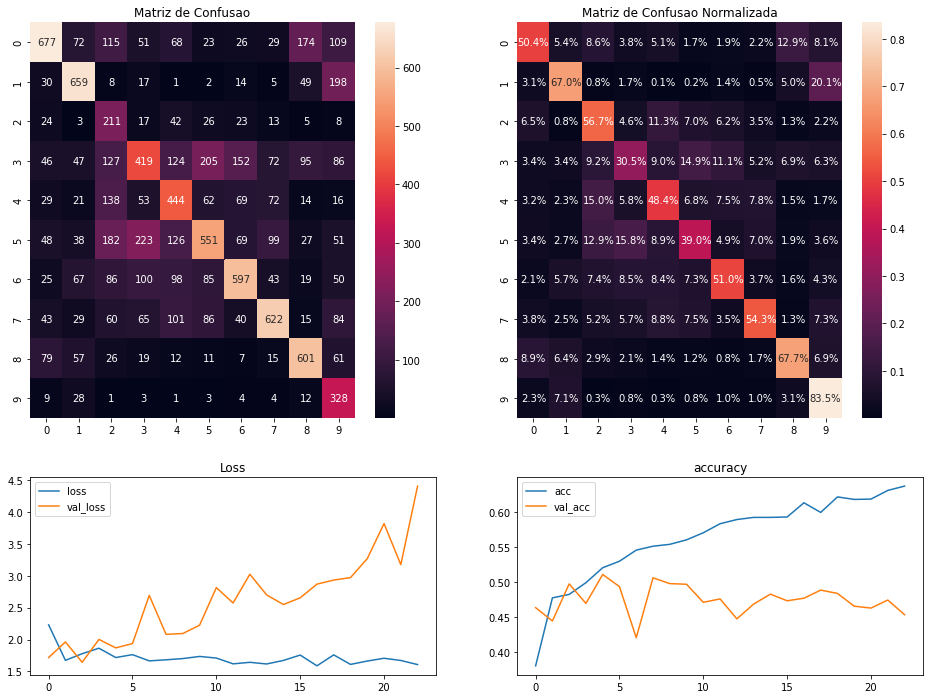

In [104]:
print_evaluate(model_baseline_tan,history_model_baseline_tan, x_val, y_val_f, 'model_tan.h5')

### 3.3 - selu

In [105]:
# Modelo Vanilla com Funcao de Ativacao SeLu

model_baseline_selu = ret_model_vanila(activation='selu')

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_50 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 10)                81930     
Total params: 82,826
Trainable params: 82,826
Non-trainable params: 0
_________________________________________________________________


In [106]:
filepath="model_selu.h5"
early_stop = EarlyStopping(monitor='val_loss',patience=20)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


history_model_baseline_selu= model_baseline_selu.fit(x_train, y_train_f,
                                                    epochs = 64, batch_size = 32,                                        
                                                    validation_data=(x_val, y_val_f),
                                                    callbacks=[early_stop, checkpoint] )

Epoch 1/64
1250/1250 [==============================] - 3s 2ms/step - loss: 2.2104 - accuracy: 0.3665 - val_loss: 1.7323 - val_accuracy: 0.4620

Epoch 00001: val_accuracy improved from -inf to 0.46200, saving model to model_selu.h5
Epoch 2/64
1250/1250 [==============================] - 3s 2ms/step - loss: 2.0976 - accuracy: 0.4349 - val_loss: 1.8176 - val_accuracy: 0.4651

Epoch 00002: val_accuracy improved from 0.46200 to 0.46510, saving model to model_selu.h5
Epoch 3/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.9780 - accuracy: 0.4678 - val_loss: 2.3967 - val_accuracy: 0.4159

Epoch 00003: val_accuracy did not improve from 0.46510
Epoch 4/64
1250/1250 [==============================] - 3s 2ms/step - loss: 2.1987 - accuracy: 0.4755 - val_loss: 1.8511 - val_accuracy: 0.4972

Epoch 00004: val_accuracy improved from 0.46510 to 0.49720, saving model to model_selu.h5
Epoch 5/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.8520 - accuracy: 0.5


Fazendo Predicoes da Validacao



Acurácia balanceada: 0.5209205059127149 



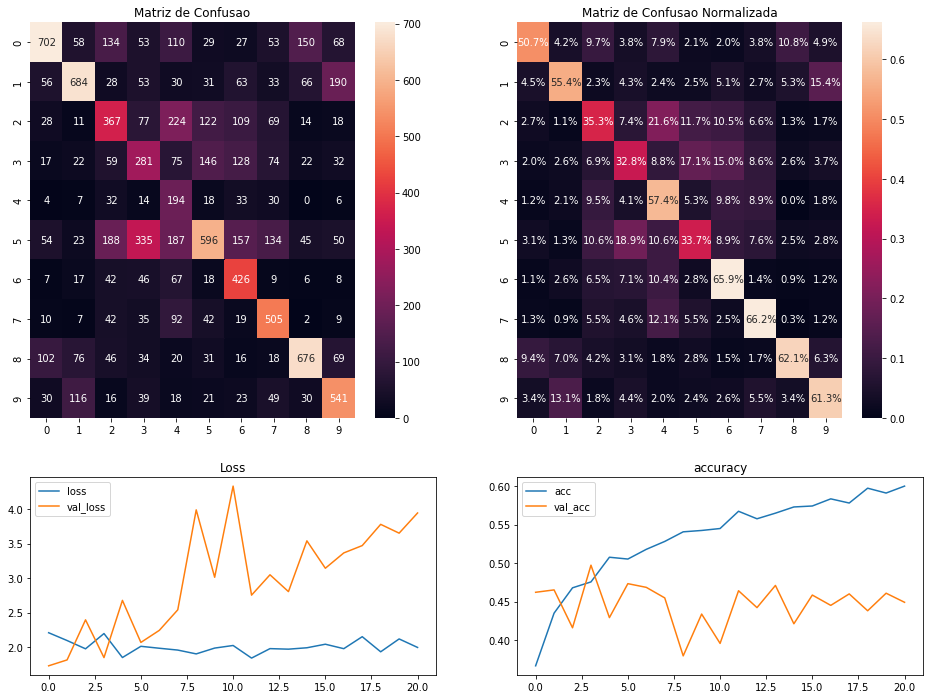

In [107]:
print_evaluate(model_baseline_selu,history_model_baseline_selu, x_val, y_val_f, 'model_selu.h5')

# 4) Variacao da quantidade de camadas de convolucao e pooling (2,5) 

Explore o impacto de variar a quantidade de camadas de convolução e pooling. Cuidado com overfitting! Explore, no mínimo, duas arquiteturas diferentes do baseline.

4.1 - Primeira rede


In [200]:
# Rede Neural com mais camadas de convolucao e pooling

model_conv_p_01 = tf.keras.Sequential()

#Camada convolucional com 10 filtros de tamanho 3x3 e ativação ReLU
model_conv_p_01.add(Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3)))
#Max pooling de tamanho 2x2
model_conv_p_01.add(MaxPooling2D(pool_size=(2,2)))

#Camada convolucional com 10 filtros de tamanho 3x3 e ativação ReLU
model_conv_p_01.add(Conv2D(64, 3, padding='same', activation='relu'))
#Max pooling de tamanho 2x2
model_conv_p_01.add(MaxPooling2D(pool_size=(2,2)))

#Operação de vetorização dos dados
model_conv_p_01.add(Flatten())

# FC
model_conv_p_01.add(Dense(1028, activation='relu'))

#Densa com 10 nós de saída
model_conv_p_01.add(Dense(10, activation='softmax'))

model_conv_p_01.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])

model_conv_p_01.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_107 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_33 (Flatten)         (None, 4096)              0         
_________________________________________________________________
dense_53 (Dense)             (None, 1028)              4211716   
_________________________________________________________________
dense_54 (Dense)             (None, 10)              

In [201]:
filepath="model_conv_p_01.h5"
early_stop = EarlyStopping(monitor='val_loss',patience=20)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


history_model_conv_p_01= model_conv_p_01.fit(x_train, y_train_f,
                                                    epochs = 64, batch_size = 32,                                        
                                                    validation_data=(x_val, y_val_f),
                                                    callbacks=[early_stop, checkpoint] )

Epoch 1/64
1250/1250 [==============================] - 4s 3ms/step - loss: 1.3498 - accuracy: 0.5177 - val_loss: 1.0999 - val_accuracy: 0.6058

Epoch 00001: val_accuracy improved from -inf to 0.60580, saving model to model_conv_p_01.h5
Epoch 2/64
1250/1250 [==============================] - 4s 3ms/step - loss: 0.9529 - accuracy: 0.6672 - val_loss: 0.9427 - val_accuracy: 0.6631

Epoch 00002: val_accuracy improved from 0.60580 to 0.66310, saving model to model_conv_p_01.h5
Epoch 3/64
1250/1250 [==============================] - 4s 3ms/step - loss: 0.7432 - accuracy: 0.7400 - val_loss: 0.8585 - val_accuracy: 0.7029

Epoch 00003: val_accuracy improved from 0.66310 to 0.70290, saving model to model_conv_p_01.h5
Epoch 4/64
1250/1250 [==============================] - 4s 3ms/step - loss: 0.5588 - accuracy: 0.8044 - val_loss: 0.8790 - val_accuracy: 0.7054

Epoch 00004: val_accuracy improved from 0.70290 to 0.70540, saving model to model_conv_p_01.h5
Epoch 5/64
1250/1250 [=====================


Fazendo Predicoes da Validacao



Acurácia balanceada: 0.7150821885983071 



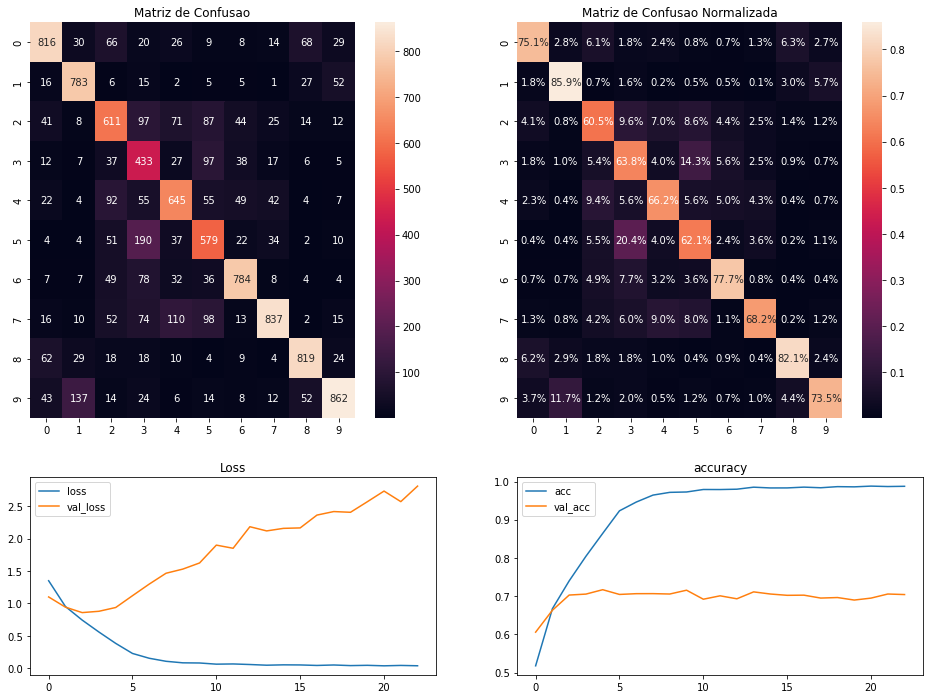

In [202]:
print_evaluate(model_conv_p_01,history_model_conv_p_01, x_val, y_val_f, 'model_conv_p_01.h5')

4.2 - Segunda CNN

Teste de filtro em cima de filtro, diminuindo a quantidade de parâmetros




In [206]:
model_ff = Sequential()

# 1- set
# CONV 
model_ff.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(32, 32, 3),padding='same' ,activation='relu',))
model_ff.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(32, 32, 3),padding='same' ,activation='relu',))
# POOLING LAYER
model_ff.add(MaxPool2D(pool_size=(2, 2)))

# 2- set
# CONV 
model_ff.add(Conv2D(filters=64, kernel_size=(3,3),padding='same', activation='relu',))
# POOLING LAYER
model_ff.add(MaxPool2D(pool_size=(2, 2)))

model_ff.add(Flatten())
# 3- FC
model_ff.add(Dense(256, activation='relu'))

model_ff.add(Dense(10, activation='sigmoid'))


model_ff.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])



model_ff.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_112 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_35 (Flatten)         (None, 4096)              0         
_________________________________________________________________
dense_57 (Dense)             (None, 256)             

In [207]:
filepath="model_ff.h5"
early_stop = EarlyStopping(monitor='val_loss',patience=20)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


history_model_ff= model_ff.fit(x_train, y_train_f,
                               epochs = 64, batch_size = 32,                                        
                               validation_data=(x_val, y_val_f),
                               callbacks=[early_stop, checkpoint] )

Epoch 1/64
1250/1250 [==============================] - 5s 3ms/step - loss: 1.3993 - accuracy: 0.4978 - val_loss: 1.0800 - val_accuracy: 0.6113

Epoch 00001: val_accuracy improved from -inf to 0.61130, saving model to model_ff.h5
Epoch 2/64
1250/1250 [==============================] - 4s 3ms/step - loss: 0.9429 - accuracy: 0.6697 - val_loss: 0.8957 - val_accuracy: 0.6841

Epoch 00002: val_accuracy improved from 0.61130 to 0.68410, saving model to model_ff.h5
Epoch 3/64
1250/1250 [==============================] - 4s 3ms/step - loss: 0.7501 - accuracy: 0.7392 - val_loss: 0.8499 - val_accuracy: 0.6991

Epoch 00003: val_accuracy improved from 0.68410 to 0.69910, saving model to model_ff.h5
Epoch 4/64
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6003 - accuracy: 0.7906 - val_loss: 0.8256 - val_accuracy: 0.7207

Epoch 00004: val_accuracy improved from 0.69910 to 0.72070, saving model to model_ff.h5
Epoch 5/64
1250/1250 [==============================] - 4s 3ms/step - l


Fazendo Predicoes da Validacao



Acurácia balanceada: 0.7214469598384826 



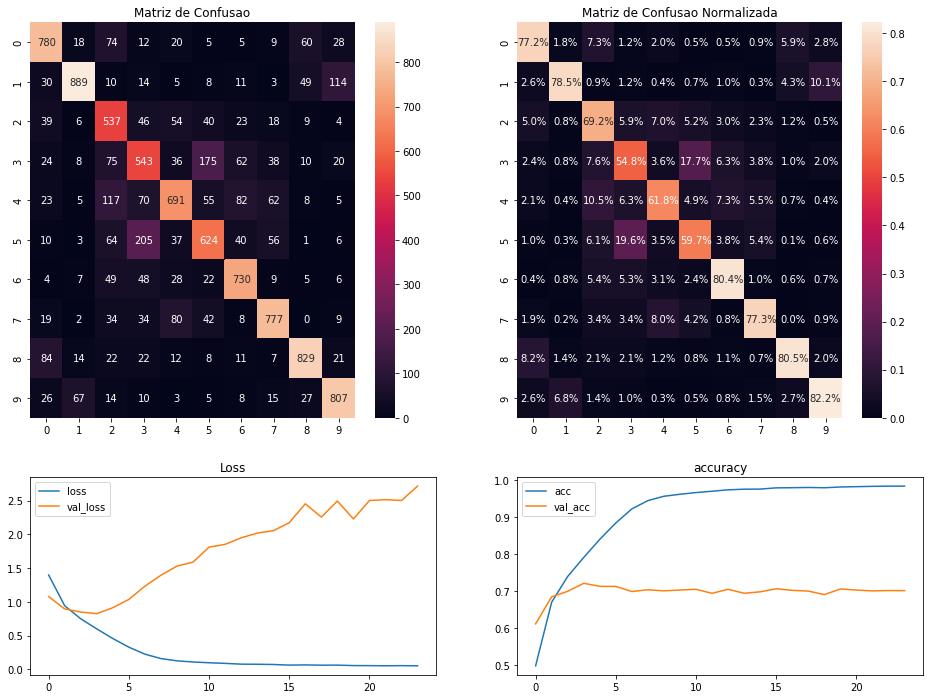

In [208]:
print_evaluate(model_ff,history_model_ff, x_val, y_val_f, 'model_ff.h5')

Esse estudo sem variação de inicialização , dropout e outros induz a produzir redes mais simples , a rede treinada tem o viés de cair sempre em algum mínimo local

# 5) Explorando Inicializações e regularizações (1,5)
'glorot_normal' vs 'random_normal'

### 5.1 - glorot_normal
Teste com rede com menor quantidade de parametros

In [203]:
model_ff_r_01 = Sequential()

# 1- set
# CONV 
model_ff_r_01.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(32, 32, 3),padding='same' ,activation='relu',kernel_initializer='glorot_normal'))
model_ff_r_01.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(32, 32, 3),padding='same' ,activation='relu',))
# POOLING LAYER
model_ff_r_01.add(MaxPool2D(pool_size=(2, 2)))

# 2- set
# CONV 
model_ff_r_01.add(Conv2D(filters=64, kernel_size=(3,3),padding='same', activation='relu',))
# POOLING LAYER
model_ff_r_01.add(MaxPool2D(pool_size=(2, 2)))

model_ff_r_01.add(Flatten())
# 3- FC
model_ff_r_01.add(Dense(256, activation='relu'))

model_ff_r_01.add(Dense(10, activation='sigmoid'))


model_ff_r_01.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])



model_ff_r_01.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_109 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_110 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_111 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_34 (Flatten)         (None, 4096)              0         
_________________________________________________________________
dense_55 (Dense)             (None, 256)             

In [204]:
filepath="model_ff_r_01.h5"
early_stop = EarlyStopping(monitor='val_loss',patience=20)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


history_model_ff_r_01= model_ff_r_01.fit(x_train, y_train_f,
                               epochs = 64, batch_size = 32,                                        
                               validation_data=(x_val, y_val_f),
                               callbacks=[early_stop, checkpoint] )

Epoch 1/64
1250/1250 [==============================] - 5s 3ms/step - loss: 1.3676 - accuracy: 0.5087 - val_loss: 1.0762 - val_accuracy: 0.6229

Epoch 00001: val_accuracy improved from -inf to 0.62290, saving model to model_ff_r_01.h5
Epoch 2/64
1250/1250 [==============================] - 4s 3ms/step - loss: 0.9321 - accuracy: 0.6738 - val_loss: 0.8710 - val_accuracy: 0.6947

Epoch 00002: val_accuracy improved from 0.62290 to 0.69470, saving model to model_ff_r_01.h5
Epoch 3/64
1250/1250 [==============================] - 4s 3ms/step - loss: 0.7346 - accuracy: 0.7441 - val_loss: 0.8150 - val_accuracy: 0.7197

Epoch 00003: val_accuracy improved from 0.69470 to 0.71970, saving model to model_ff_r_01.h5
Epoch 4/64
1250/1250 [==============================] - 4s 3ms/step - loss: 0.5836 - accuracy: 0.7953 - val_loss: 0.7862 - val_accuracy: 0.7309

Epoch 00004: val_accuracy improved from 0.71970 to 0.73090, saving model to model_ff_r_01.h5
Epoch 5/64
1250/1250 [=============================


Fazendo Predicoes da Validacao



Acurácia balanceada: 0.7371486288963375 



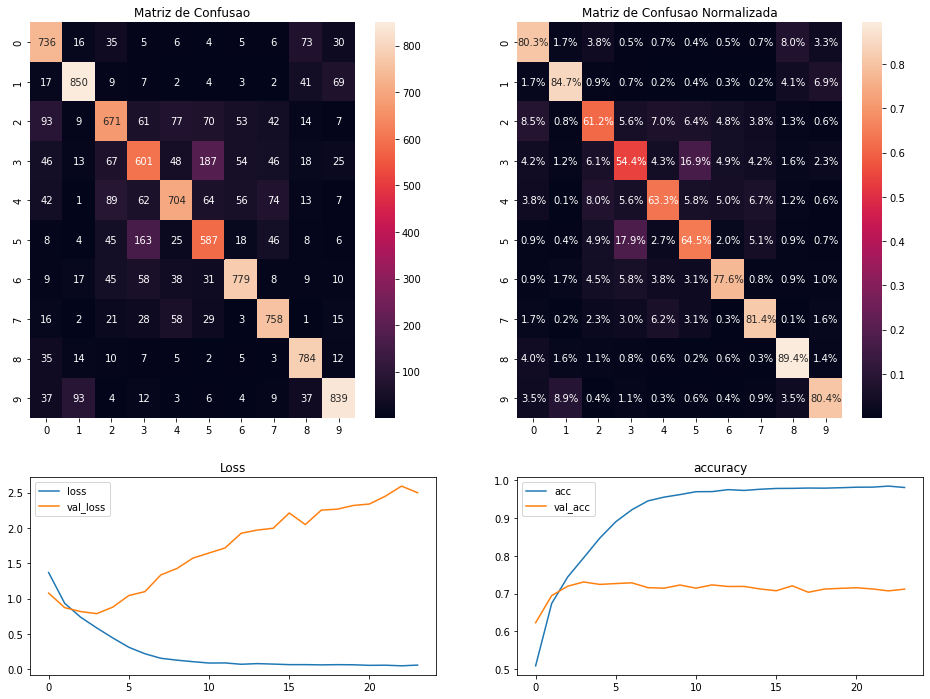

In [205]:
print_evaluate(model_ff_r_01,history_model_ff_r_01, x_val, y_val_f, 'model_ff_r_01.h5')

com a inicialização kernel_initializer='glorot_normal' , a rede fica em um minimo local, não tem variáveis para tirar ela de lá, na teoria sem os dropouts algo que  poderia melhora é deixar o modelo mais simples

### 5.2 - random_normal

In [182]:

model_ff_r_02 = Sequential()

# 1- set
# CONV 
model_ff_r_02.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(32, 32, 3),padding='same' ,activation='relu',kernel_initializer='random_normal'))
model_ff_r_02.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(32, 32, 3),padding='same' ,activation='relu',))
# POOLING LAYER
model_ff_r_02.add(MaxPool2D(pool_size=(2, 2)))

# 2- set
# CONV 
model_ff_r_02.add(Conv2D(filters=64, kernel_size=(3,3),padding='same', activation='relu',))
# POOLING LAYER
model_ff_r_02.add(MaxPool2D(pool_size=(2, 2)))

model_ff_r_02.add(Flatten())
# 3- FC
model_ff_r_02.add(Dense(256, activation='relu'))

model_ff_r_02.add(Dense(10, activation='sigmoid'))


model_ff_r_02.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])





model_ff_r_02.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_104 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_32 (Flatten)         (None, 4096)              0         
_________________________________________________________________
dense_51 (Dense)             (None, 256)             

In [183]:
filepath="model_ff_r_02.h5"
early_stop = EarlyStopping(monitor='val_loss',patience=20)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


history_model_ff_r_02= model_ff_r_02.fit(x_train, y_train_f,
                               epochs = 64, batch_size = 32,                                        
                               validation_data=(x_val, y_val_f),
                               callbacks=[early_stop, checkpoint] )

Epoch 1/64
1250/1250 [==============================] - 5s 3ms/step - loss: 1.4042 - accuracy: 0.4965 - val_loss: 1.0862 - val_accuracy: 0.6169

Epoch 00001: val_accuracy improved from -inf to 0.61690, saving model to model_ff_r_02.h5
Epoch 2/64
1250/1250 [==============================] - 4s 3ms/step - loss: 0.9417 - accuracy: 0.6686 - val_loss: 0.8748 - val_accuracy: 0.6868

Epoch 00002: val_accuracy improved from 0.61690 to 0.68680, saving model to model_ff_r_02.h5
Epoch 3/64
1250/1250 [==============================] - 4s 3ms/step - loss: 0.7567 - accuracy: 0.7368 - val_loss: 0.8631 - val_accuracy: 0.6984

Epoch 00003: val_accuracy improved from 0.68680 to 0.69840, saving model to model_ff_r_02.h5
Epoch 4/64
1250/1250 [==============================] - 4s 3ms/step - loss: 0.6134 - accuracy: 0.7847 - val_loss: 0.8089 - val_accuracy: 0.7202

Epoch 00004: val_accuracy improved from 0.69840 to 0.72020, saving model to model_ff_r_02.h5
Epoch 5/64
1250/1250 [=============================


Fazendo Predicoes da Validacao



Acurácia balanceada: 0.7234387910503208 



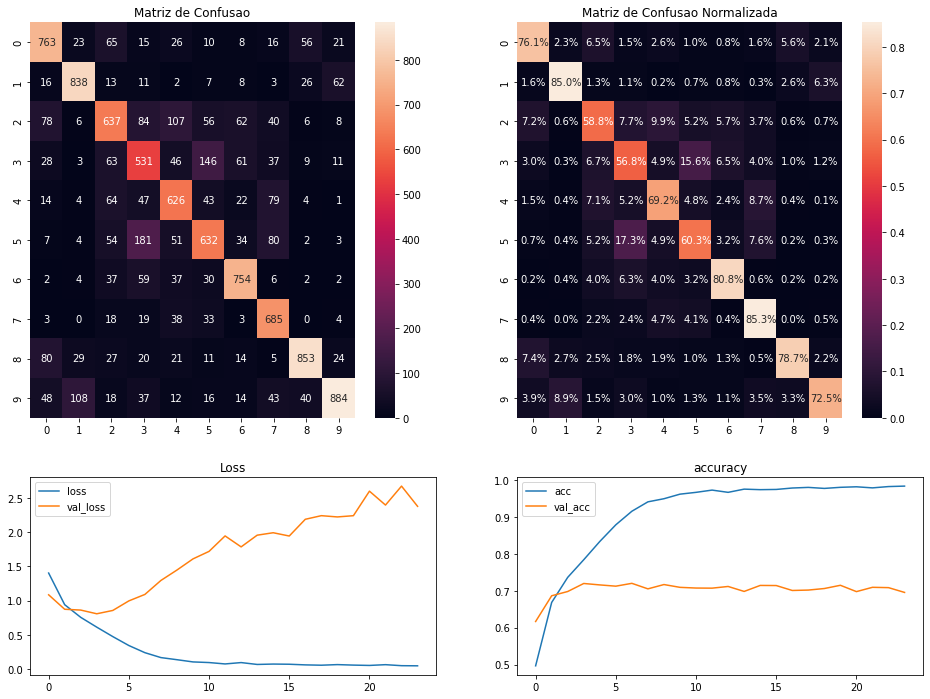

In [184]:
print_evaluate(model_ff_r_02,history_model_ff_r_02, x_val, y_val_f, 'model_ff_r_02.h5')

### 5.3 - testes com Baseline
devido a complexidade alta e o modelo não estar conseguindo se ajustar, vamos testar com modelos mais simples variando a inicialização e regularizão


#### 5.3.1 - Baseline - inicialização glorot_normal

In [42]:
# Rede Neural Vanilla

model_baseline_r_gn = tf.keras.Sequential()
#Camada convolucional com 32 filtros de tamanho 3x3 e ativação ReLU
model_baseline_r_gn.add(Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3), kernel_initializer='glorot_normal'))
#Max pooling de tamanho 2x2
model_baseline_r_gn.add(MaxPooling2D(pool_size=(2,2)))
#Operação de vetorização dos dados
model_baseline_r_gn.add(Flatten())
#Densa com 10 nós de saída
model_baseline_r_gn.add(Dense(10 ,activation = 'softmax'))

model_baseline_r_gn.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model_baseline_r_gn.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                81930     
Total params: 82,826
Trainable params: 82,826
Non-trainable params: 0
_________________________________________________________________


In [43]:
filepath="model_baseline_r_gn.h5"
early_stop = EarlyStopping(monitor='val_loss',patience=20)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


history_model_baseline_r_gn= model_baseline_r_gn.fit(x_train, y_train_f,
                               epochs = 64, batch_size = 32,                                        
                               validation_data=(x_val, y_val_f),
                               callbacks=[early_stop, checkpoint] )

Epoch 1/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.9134 - accuracy: 0.3234 - val_loss: 1.8072 - val_accuracy: 0.3439

Epoch 00001: val_accuracy improved from -inf to 0.34390, saving model to model_baseline_r_gn.h5
Epoch 2/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.8034 - accuracy: 0.3604 - val_loss: 1.8164 - val_accuracy: 0.3554

Epoch 00002: val_accuracy improved from 0.34390 to 0.35540, saving model to model_baseline_r_gn.h5
Epoch 3/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.7880 - accuracy: 0.3680 - val_loss: 1.7752 - val_accuracy: 0.3671

Epoch 00003: val_accuracy improved from 0.35540 to 0.36710, saving model to model_baseline_r_gn.h5
Epoch 4/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.7705 - accuracy: 0.3740 - val_loss: 1.8905 - val_accuracy: 0.3151

Epoch 00004: val_accuracy did not improve from 0.36710
Epoch 5/64
1250/1250 [==============================] - 3s 2ms/step - l


Fazendo Predicoes da Validacao



Acurácia balanceada: 0.38105068127003905 



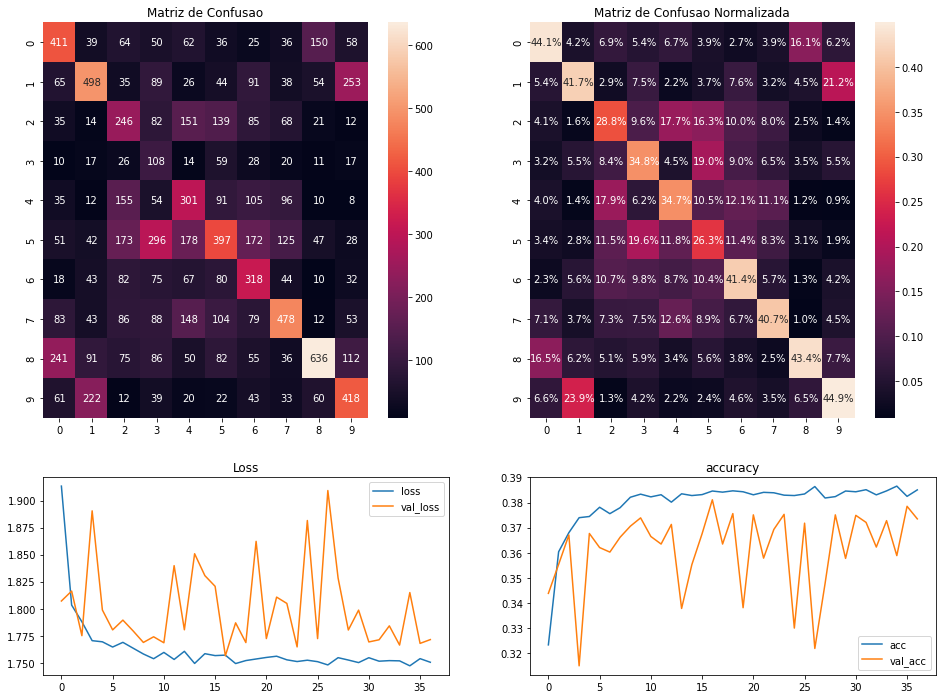

In [44]:
print_evaluate(model_baseline_r_gn,history_model_baseline_r_gn, x_val, y_val_f, 'model_baseline_r_gn.h5')

#### 5.3.2 - Baseline - inicialização random_normal

In [45]:
# Rede Neural Vanilla

model_baseline_r_rn = tf.keras.Sequential()
#Camada convolucional com 32 filtros de tamanho 3x3 e ativação ReLU
model_baseline_r_rn.add(Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3), kernel_initializer='random_normal'))
#Max pooling de tamanho 2x2
model_baseline_r_rn.add(MaxPooling2D(pool_size=(2,2)))
#Operação de vetorização dos dados
model_baseline_r_rn.add(Flatten())
#Densa com 10 nós de saída
model_baseline_r_rn.add(Dense(10 ,activation = 'softmax'))

model_baseline_r_rn.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model_baseline_r_rn.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                81930     
Total params: 82,826
Trainable params: 82,826
Non-trainable params: 0
_________________________________________________________________


In [46]:
filepath="model_baseline_r_rn.h5"
early_stop = EarlyStopping(monitor='val_loss',patience=20)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


history_model_baseline_r_rn= model_baseline_r_rn.fit(x_train, y_train_f,
                               epochs = 64, batch_size = 32,                                        
                               validation_data=(x_val, y_val_f),
                               callbacks=[early_stop, checkpoint] )

Epoch 1/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.9325 - accuracy: 0.3052 - val_loss: 1.7881 - val_accuracy: 0.3600

Epoch 00001: val_accuracy improved from -inf to 0.36000, saving model to model_baseline_r_rn.h5
Epoch 2/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.7935 - accuracy: 0.3559 - val_loss: 1.8481 - val_accuracy: 0.3502

Epoch 00002: val_accuracy did not improve from 0.36000
Epoch 3/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.7780 - accuracy: 0.3626 - val_loss: 1.8085 - val_accuracy: 0.3585

Epoch 00003: val_accuracy did not improve from 0.36000
Epoch 4/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.7737 - accuracy: 0.3650 - val_loss: 1.8097 - val_accuracy: 0.3430

Epoch 00004: val_accuracy did not improve from 0.36000
Epoch 5/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.7666 - accuracy: 0.3668 - val_loss: 1.7714 - val_accuracy: 0.3578

Epoch 00005: v


Fazendo Predicoes da Validacao



Acurácia balanceada: 0.3856809562166497 



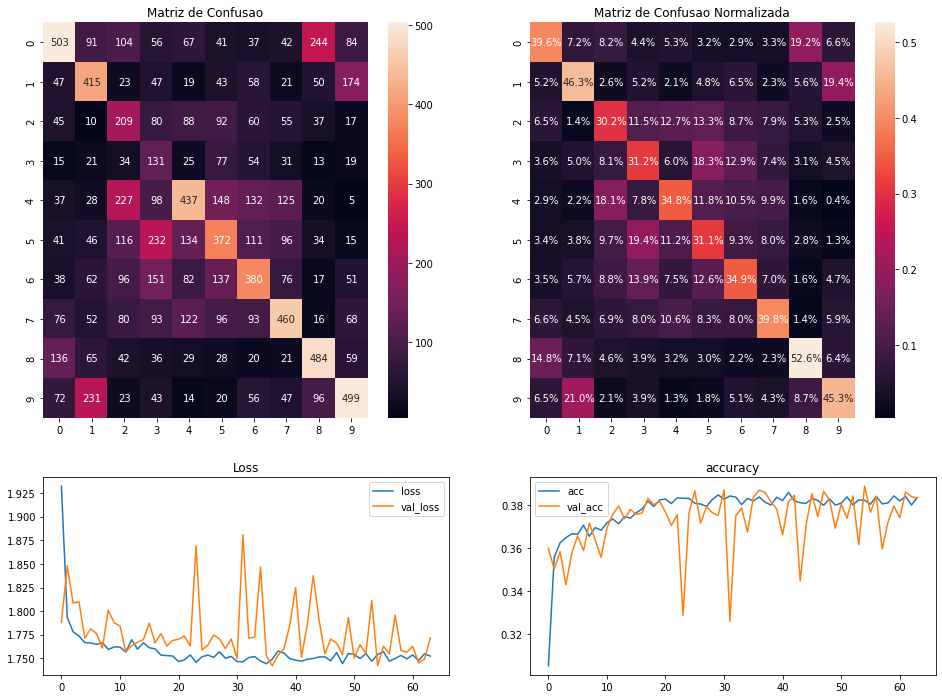

In [47]:
print_evaluate(model_baseline_r_rn,history_model_baseline_r_rn, x_val, y_val_f, 'model_baseline_r_rn.h5')

parece um viés de confirmação, porém a inicialização glorot_normal apresentou melhores resultados , vamos explorar agora um pouco as regularizações e funções de normalização

#### 5.3.3 - Baseline - inicialização glorot_normal com regularização e normalização


In [48]:
# Rede Neural Vanilla

model_baseline_r_gn_n = tf.keras.Sequential()
#Camada convolucional com 32 filtros de tamanho 3x3 e ativação ReLU
model_baseline_r_gn_n.add(Conv2D(32, 3, padding='same', activation='relu', input_shape=(32, 32, 3), kernel_initializer='glorot_normal', kernel_regularizer=regularizers.l2(0.01)))
model_baseline_r_gn_n.add(BatchNormalization())

#Max pooling de tamanho 2x2
model_baseline_r_gn_n.add(MaxPooling2D(pool_size=(2,2)))
#Operação de vetorização dos dados
model_baseline_r_gn_n.add(Flatten())
#Densa com 10 nós de saída
model_baseline_r_gn_n.add(Dense(10 ,activation = 'softmax'))

model_baseline_r_gn_n.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model_baseline_r_gn_n.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)                81930     
Total params: 82,954
Trainable params: 82,890
Non-trainable params: 64
_________________________________________________________________


In [49]:
filepath="model_baseline_r_gn_n.h5"
early_stop = EarlyStopping(monitor='val_loss',patience=20)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


history_model_baseline_r_gn_n= model_baseline_r_gn_n.fit(x_train, y_train_f,
                               epochs = 64, batch_size = 32,                                        
                               validation_data=(x_val, y_val_f),
                               callbacks=[early_stop, checkpoint] )

Epoch 1/64
1250/1250 [==============================] - 4s 3ms/step - loss: 1.9593 - accuracy: 0.4296 - val_loss: 1.9990 - val_accuracy: 0.3756

Epoch 00001: val_accuracy improved from -inf to 0.37560, saving model to model_baseline_r_gn_n.h5
Epoch 2/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.4808 - accuracy: 0.5062 - val_loss: 1.6114 - val_accuracy: 0.4811

Epoch 00002: val_accuracy improved from 0.37560 to 0.48110, saving model to model_baseline_r_gn_n.h5
Epoch 3/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.4528 - accuracy: 0.5224 - val_loss: 1.5219 - val_accuracy: 0.5139

Epoch 00003: val_accuracy improved from 0.48110 to 0.51390, saving model to model_baseline_r_gn_n.h5
Epoch 4/64
1250/1250 [==============================] - 3s 2ms/step - loss: 1.4342 - accuracy: 0.5315 - val_loss: 1.5817 - val_accuracy: 0.4837

Epoch 00004: val_accuracy did not improve from 0.51390
Epoch 5/64
1250/1250 [==============================] - 3s 2ms/st


Fazendo Predicoes da Validacao



Acurácia balanceada: 0.5543384807208438 



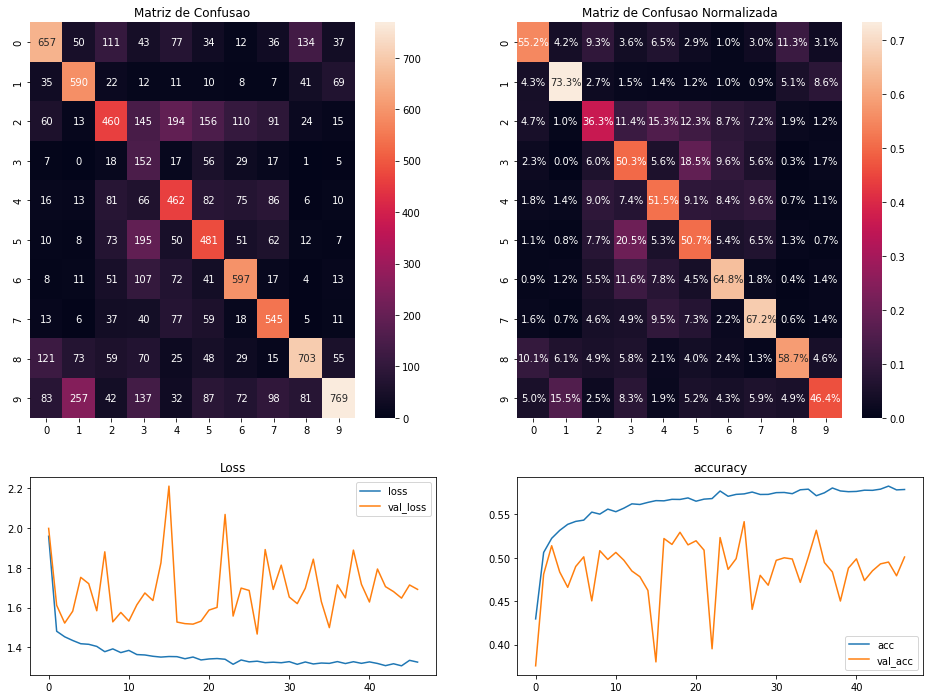

In [50]:
print_evaluate(model_baseline_r_gn_n,history_model_baseline_r_gn_n, x_val, y_val_f, 'model_baseline_r_gn_n.h5')

Com regularização e normalização a rede alcançou acurácias maiores mais rapido *


# 6. Avalie o Uso de Dropout

####  6.1 - teste com uma rede um pouco mais robusta
Validando se com dropout a rede consegue sair dos mínimos locais

In [51]:
model_skw_01 = Sequential()

# 1- set
# CONV 
model_skw_01.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(32, 32, 3),padding='same' ,activation='relu',))
# NORM
model_skw_01.add(BatchNormalization())
# CONV 
model_skw_01.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(32, 32, 3),padding='same', activation='relu',))
# NORM
model_skw_01.add(BatchNormalization())
# POOLING LAYER
model_skw_01.add(MaxPool2D(pool_size=(2, 2)))

# 2- set
model_skw_01.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=(32, 32, 3),padding='same', activation='relu',))
# NORM
model_skw_01.add(BatchNormalization())
# POOLING LAYER
model_skw_01.add(MaxPool2D(pool_size=(2, 2)))

model_skw_01.add(Flatten())
#sem sentido esse dropout
model_skw_01.add(Dropout(0.2))

model_skw_01.add(Dense(1024, activation='relu'))

model_skw_01.add(Dropout(0.2))

model_skw_01.add(Dense(10, activation='sigmoid'))


model_skw_01.compile(optimizer=tf.keras.optimizers.Adam(0.01),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])



model_skw_01.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 64)      

De 81k foi para 4,2kk parâmetros

In [52]:
filepath="model_skw_01.h5"
early_stop = EarlyStopping(monitor='val_loss',patience=20)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


history_model_skw_01= model_skw_01.fit(x_train, y_train_f,
                               epochs = 64, batch_size = 32,                                        
                               validation_data=(x_val, y_val_f),
                               callbacks=[early_stop, checkpoint] )

Epoch 1/64
1250/1250 [==============================] - 6s 4ms/step - loss: 2.5697 - accuracy: 0.2799 - val_loss: 1.9837 - val_accuracy: 0.3283

Epoch 00001: val_accuracy improved from -inf to 0.32830, saving model to model_skw_01.h5
Epoch 2/64
1250/1250 [==============================] - 5s 4ms/step - loss: 1.5425 - accuracy: 0.4448 - val_loss: 1.4409 - val_accuracy: 0.4998

Epoch 00002: val_accuracy improved from 0.32830 to 0.49980, saving model to model_skw_01.h5
Epoch 3/64
1250/1250 [==============================] - 5s 4ms/step - loss: 1.3509 - accuracy: 0.5364 - val_loss: 1.5029 - val_accuracy: 0.5195

Epoch 00003: val_accuracy improved from 0.49980 to 0.51950, saving model to model_skw_01.h5
Epoch 4/64
1250/1250 [==============================] - 5s 4ms/step - loss: 1.2638 - accuracy: 0.5719 - val_loss: 1.2401 - val_accuracy: 0.5872

Epoch 00004: val_accuracy improved from 0.51950 to 0.58720, saving model to model_skw_01.h5
Epoch 5/64
1250/1250 [==============================] -


Fazendo Predicoes da Validacao



Acurácia balanceada: 0.6989446205640524 



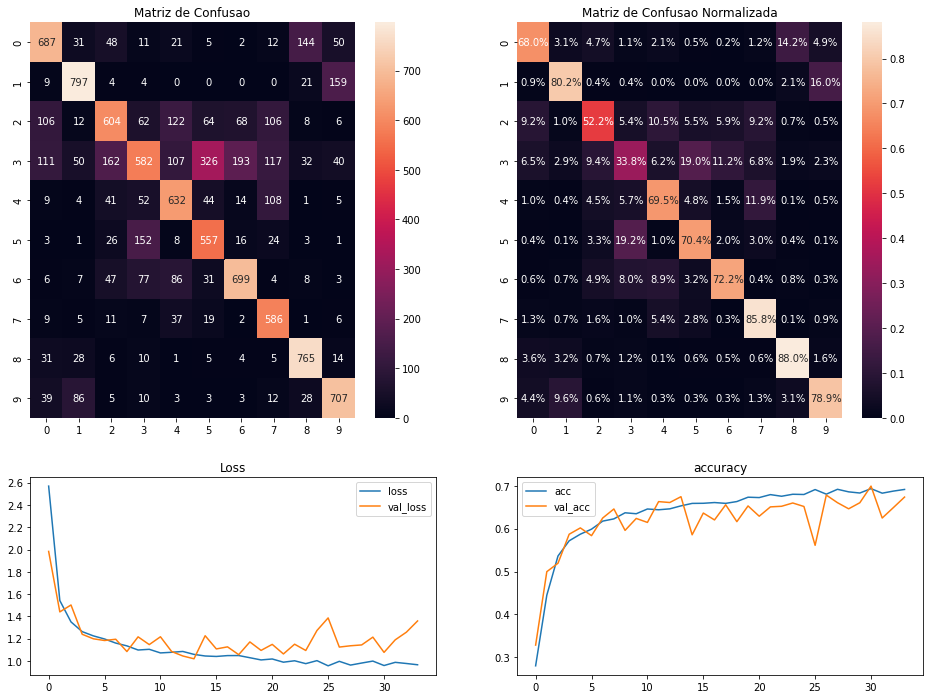

In [53]:
print_evaluate(model_skw_01,history_model_skw_01, x_val, y_val_f, 'model_skw_01.h5')

Com o Dropout a rede consegue sair de mínimos locais, vamos almentar as camadas de complexidade para verificar a evolução, pelos gráficos de loss e accuray a rede ainda não apresentou nas epochs regiões de overfitting

####  6.2 - teste com uma rede com mais camadas complexas
Validando se conseguimos melhorar a acuracia da rede

In [54]:
model_skw_02 = Sequential()


# 1- set
# CONV 
model_skw_02.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(32, 32, 3),padding='same' ,activation='relu',))
# NORM
model_skw_02.add(BatchNormalization())
# CONV 
model_skw_02.add(Conv2D(filters=64, kernel_size=(3,3),padding='same', activation='relu',))
# NORM
model_skw_02.add(BatchNormalization())
# POOLING LAYER
model_skw_02.add(MaxPool2D(pool_size=(2, 2)))


# 2- set
model_skw_02.add(Conv2D(filters=32, kernel_size=(3,3),padding='same', activation='relu',))
# NORM
model_skw_02.add(BatchNormalization())
# CONV 
model_skw_02.add(Conv2D(filters=64, kernel_size=(3,3),padding='same', activation='relu',))
# NORM
model_skw_02.add(BatchNormalization())
# POOLING LAYER
model_skw_02.add(MaxPool2D(pool_size=(2, 2)))

# 3 - set

model_skw_02.add(Conv2D(filters=128, kernel_size=(3,3),padding='same', activation='relu',))
# NORM
model_skw_02.add(BatchNormalization())
# CONV 
model_skw_02.add(Conv2D(filters=128, kernel_size=(3,3),padding='same', activation='relu',))
# NORM
model_skw_02.add(BatchNormalization())
# POOLING LAYER
model_skw_02.add(MaxPool2D(pool_size=(2, 2)))


# 4- FC
model_skw_02.add(Flatten())
#sem sentido esse dropout
model_skw_02.add(Dropout(0.2))
# DENSE 01
model_skw_02.add(Dense(1024, activation='relu'))

model_skw_02.add(Dropout(0.2))
# DENSE 02
model_skw_02.add(Dense(10, activation='sigmoid'))


model_skw_02.compile(optimizer=tf.keras.optimizers.Adam(0.01),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])



model_skw_02.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 16, 16, 32)        18464     
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 32)      

In [55]:
filepath="model_skw_02.h5"
early_stop = EarlyStopping(monitor='val_loss',patience=40)
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


history_model_skw_02= model_skw_02.fit(x_train, y_train_f,
                               epochs = 128, batch_size = 32,                                        
                               validation_data=(x_val, y_val_f),
                               callbacks=[early_stop, checkpoint] )

Epoch 1/128
1250/1250 [==============================] - 8s 6ms/step - loss: 2.4522 - accuracy: 0.2836 - val_loss: 2.4045 - val_accuracy: 0.3008

Epoch 00001: val_accuracy improved from -inf to 0.30080, saving model to model_skw_02.h5
Epoch 2/128
1250/1250 [==============================] - 7s 5ms/step - loss: 1.5963 - accuracy: 0.4213 - val_loss: 1.7433 - val_accuracy: 0.5275

Epoch 00002: val_accuracy improved from 0.30080 to 0.52750, saving model to model_skw_02.h5
Epoch 3/128
1250/1250 [==============================] - 7s 5ms/step - loss: 1.2989 - accuracy: 0.5465 - val_loss: 2.6374 - val_accuracy: 0.6003

Epoch 00003: val_accuracy improved from 0.52750 to 0.60030, saving model to model_skw_02.h5
Epoch 4/128
1250/1250 [==============================] - 7s 5ms/step - loss: 1.1681 - accuracy: 0.6013 - val_loss: 1.3464 - val_accuracy: 0.5664

Epoch 00004: val_accuracy did not improve from 0.60030
Epoch 5/128
1250/1250 [==============================] - 7s 5ms/step - loss: 1.0782 - ac


Fazendo Predicoes da Validacao



Acurácia balanceada: 0.7388833926443652 



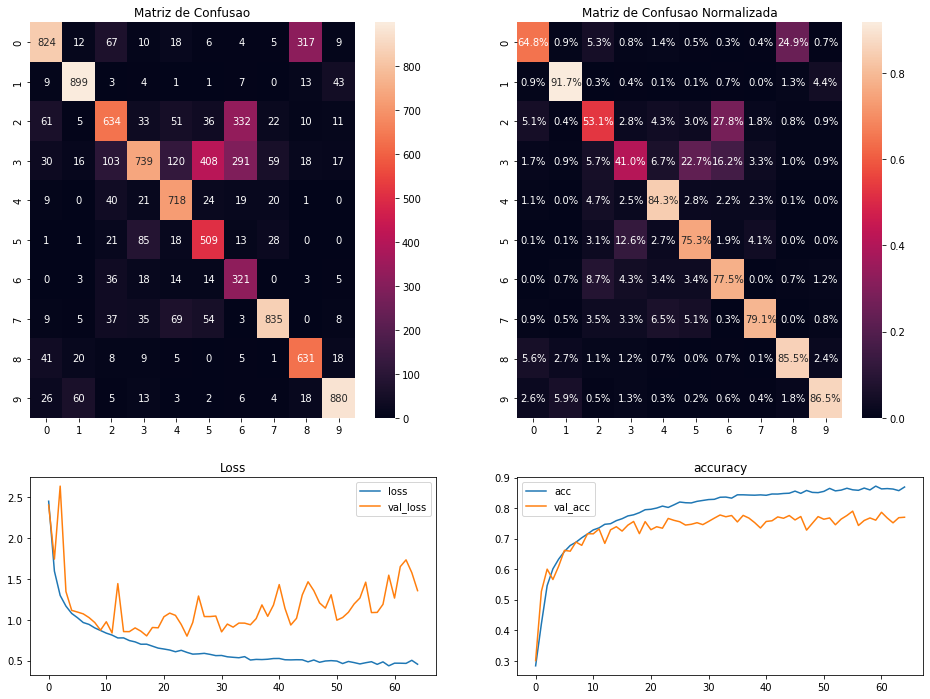

In [56]:
print_evaluate(model_skw_02,history_model_skw_02, x_val, y_val_f, 'model_skw_02.h5')

####  6.3 - teste com uma rede com mais camadas complexas
Validando se conseguimos melhorar a acuracia da rede com aumento da complexidade dos dados de entrada

In [179]:
model_skw_03 = Sequential()


# 1- set
# CONV 
model_skw_03.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(32, 32, 3),padding='same' ,activation='relu',))
# NORM
model_skw_03.add(BatchNormalization())
# CONV 
model_skw_03.add(Conv2D(filters=32, kernel_size=(3,3),padding='same', activation='relu',))
# NORM
model_skw_03.add(BatchNormalization())
# POOLING LAYER
model_skw_03.add(MaxPool2D(pool_size=(2, 2)))


# 2- set
model_skw_03.add(Conv2D(filters=64, kernel_size=(3,3),padding='same', activation='relu',))
# NORM
model_skw_03.add(BatchNormalization())
# CONV 
model_skw_03.add(Conv2D(filters=64, kernel_size=(3,3),padding='same', activation='relu',))
# NORM
model_skw_03.add(BatchNormalization())
# POOLING LAYER
model_skw_03.add(MaxPool2D(pool_size=(2, 2)))

# 3 - set

model_skw_03.add(Conv2D(filters=128, kernel_size=(3,3),padding='same', activation='relu',))
# NORM
model_skw_03.add(BatchNormalization())
# CONV 
model_skw_03.add(Conv2D(filters=128, kernel_size=(3,3),padding='same', activation='relu',))
# NORM
model_skw_03.add(BatchNormalization())
# POOLING LAYER
model_skw_03.add(MaxPool2D(pool_size=(2, 2)))


# 4- FC
model_skw_03.add(Flatten())
#sem sentido esse dropout
model_skw_03.add(Dropout(0.2))
# DENSE 01
model_skw_03.add(Dense(1024, activation='relu'))

model_skw_03.add(Dropout(0.2))
# DENSE 02
model_skw_03.add(Dense(10, activation='softmax'))


model_skw_03.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])



model_skw_03.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_98 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_70 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_71 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_60 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_100 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_72 (Batc (None, 16, 16, 64)      

In [180]:
filepath="model_skw_03_sig.h5"

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

batch_size = 32
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(x_train, y_train_f, batch_size)
steps_per_epoch = x_train.shape[0] // batch_size



history_model_skw_03= model_skw_03.fit(train_generator,steps_per_epoch=steps_per_epoch,
                                                    epochs = 256, batch_size = batch_size,                                        
                                                    validation_data=(x_val, y_val_f),
                                                    callbacks=[checkpoint]  )


Epoch 1/256
1250/1250 [==============================] - 19s 14ms/step - loss: 1.5382 - accuracy: 0.4671 - val_loss: 1.2884 - val_accuracy: 0.5648

Epoch 00001: val_accuracy improved from -inf to 0.56480, saving model to model_skw_03_sig.h5
Epoch 2/256
1250/1250 [==============================] - 18s 14ms/step - loss: 1.0705 - accuracy: 0.6226 - val_loss: 0.9423 - val_accuracy: 0.6690

Epoch 00002: val_accuracy improved from 0.56480 to 0.66900, saving model to model_skw_03_sig.h5
Epoch 3/256
1250/1250 [==============================] - 17s 14ms/step - loss: 0.9074 - accuracy: 0.6853 - val_loss: 0.8675 - val_accuracy: 0.6928

Epoch 00003: val_accuracy improved from 0.66900 to 0.69280, saving model to model_skw_03_sig.h5
Epoch 4/256
1250/1250 [==============================] - 17s 14ms/step - loss: 0.8179 - accuracy: 0.7173 - val_loss: 1.1231 - val_accuracy: 0.6615

Epoch 00004: val_accuracy did not improve from 0.69280
Epoch 5/256
1250/1250 [==============================] - 18s 14ms/st


Fazendo Predicoes da Validacao



Acurácia balanceada: 0.9019236174863536 



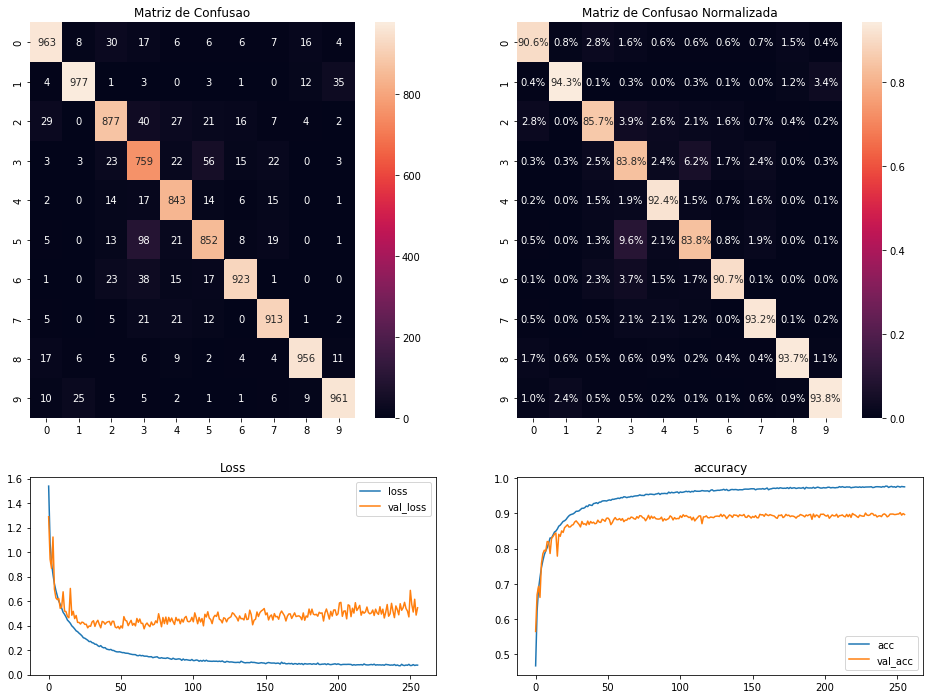

In [181]:
print_evaluate(model_skw_03,history_model_skw_03, x_val, y_val_f, 'model_skw_03_90.h5')

# 7) Plote os gráficos da função de loss×número de épocas, para o treino e validação de cada modelo. Houve overfitting?


# * ***MODIFICAR TODA A EXPLICACAO !!!! DEVIDO A MUDANCA DE LEARNING RATE OS ALGORITIMOS CONSEGUIRAM SAIR DO MINIMO LOCAL ***


<ol>
  <li> Modelo Vanilla  
  <p>Observando a acurácia dos modelos vanilla preferimos utilizar o compile do modelo com a opção SparseCategoricalCrossentropy </p>
  <p>O modelo utilizado não foi treinado extensivamente até encontrar regiões de overfitting </p>
  </li>

  <li>  Diferentes funções de ativação
    <ul>
      <li><b>sigmoide</b> - as curvas de acuracia e loss estabilizaram mais rapidamente e a acurácia balanceada foi melhor que a ativação relu, a partir do 7º epoch começa uma região de overfitting </li>
      <li><b>tangente hiperbólica</b> - as curvas de acurácia e loss não tem tanta estabilidade, porém pode-se observar uma região de overfitting a partir do 8º epoch</li>
      <li><b>selu</b> - as curvas de acurácia e loss não tem tanta estabilidade, porém pode-se observar uma região de overfitting a partir do 5º epoch</li>
    </ul>
  </li>

  <li> Variacao da quantidade de camadas de convolução e pooling
    <ul>
      <li><b>Primeira rede</b> - A rede não conseguiu sair de um mínimo local, provavelmente devido a quantidade de parâmetros, o que pode melhorar é deixar a rede mais simples </li>
      <li><b>Segunda CNN</b> -  A rede também não conseguiu sair dee um mínimo local, esse estudo sem variação de inicialização , dropout e parâmetros induz a produzir redes mais simples , a rede treinada tem o viés de cair sempre em algum mínimo local</li>
      </ul>
  </li>

  <li> Explorando Inicializações e regularizações
    <ul>
      <li><b>modelo 5.1 e 5.2  </b>
      Os primeiros testes com inicializações  <b> 'glorot_normal' e 'random_normal'  </b> foram feitos a partir de redes com menor quantidade de parâmetros comparada aos <b>4.1 e 4.1</b>, porém ainda assim observado respostas dos cms e verificando a acurácia e o loss elas por não tem dropout para forçar a rede aprendeer de outra maneira as redes ainda ficam em um minimo local,  na teoria , se incluirmos os dropouts ou diminuirmos a dificuldade da rede , elas vão começar a aprender melhor
      </li>
      <li><b>modelo 5.3.1 e 5.3.2  </b>
      Voltamos as redes de baselinee para conseguir treinar e avaliar as inicializações  <b> 'glorot_normal' e 'random_normal'  </b> em geral o resultado de ambas para a rede baseline não foi tão diferente a ponto de realmente observar as diferenças.
      </li>
          <li><b>modelo 5.3.3  </b>
          inicialização glorot_normal com regularização e normalização além de testar a inicialização também incluímos a regularização l2 essa rede comparada com a <b>5.3.1</b> teve uma melhora na acurácia balanceada na validação saindo de 38% para 55% , não pode ser observado um ponto claro de overfitting.
      </li>
    </ul>

  </li>
    <li> Avalie o Uso de Dropout
    <ul>
      <li><b>modelo 6.1  </b>
      Com o Dropout , na teoria, podemos aumentara dificuldade da rede e ainda assim ela irá conseguir encontrar uma forma adequada de aprender sem cair em um mínimo local e não conseguir sair, antes as redes que treinadas que conseguíamos obter algum tipo de resposta diferente de uma única continham aproximadamente 83k parâmetros agora temos uma rede com 4,2M parâmetros . A primeira rede foi testada um conceito de aplicar um filtro em cima de outro e com dropout de 20% nas camadas totalmente conectadas colocando camadas de normalização intermediárias. A acurácia balanceada já demonstra uma melhora expressiva saindo de 55% para 69%.
      </li>
      <li><b>modelo 6.2  </b>
      Nesse modelo tentamos aumentar a complexidade e ao mesmo tempo diminuir a quantidade de parâmetros para a rede aprender, colocamos um set de filtros  e uma camada intermediária a mais de pooling , fomos de 4,2M parâmetros para 2,4M de parâmetros. A acurácia do modelo aumentou de 69% para 73%. Pode-se observar uma região de overfitting a partir do 17º epoch.
      </li>
          <li><b>modelo 6.3 </b>
          Nesse modelo tentamos melhorar a generalização do modelo incluindo dados artificiais , a rede treinada teve uma melhora expressiva saindo de 73% para 83% da acurácia, pelo gráfico de acurácia aparentemente ela ainda poderia ser treinada por mais tempo pois até o final das epochs não apresenta regiões de overfitting. Observando o cm as labels que a rede mais confunde são de gatos comparados a cachorros, plausível *.
      </li>
    </ul>

  </li>









</ol>


# 8. (0,5) A partir dos experimentos acima, construa o que você considera o melhor modelo e faça a avaliação no conjunto de teste. 
Obs: Avaliação no conjunto de teste só pode ser executada uma única vez.

In [185]:
model_skw_03.load_weights('model_skw_03_90.h5')
predictions = model_skw_03.predict(x_test)


In [186]:
cm = confusion_matrix(np.argmax(predictions, axis=1), y_test_f)


cm_b = cm / cm.astype(np.float).sum(axis=1, keepdims=True)
balanced_acc = np.trace(cm_b) / num_classes
print("\n\nAcurácia balanceada:", balanced_acc, "\n")



Acurácia balanceada: 0.8921809660204822 



In [192]:
df_history = pd.DataFrame(history_model_skw_03.history)

In [193]:
df_history

,loss,accuracy,val_loss,val_accuracy
0,1.538192,0.467125,1.288365,0.5648
1,1.070464,0.622575,0.942317,0.6690
2,0.907355,0.685300,0.867476,0.6928
3,0.817927,0.717300,1.123108,0.6615
4,0.739926,0.746075,0.698257,0.7571
...,...,...,...,...
251,0.075391,0.976550,0.571967,0.8986
252,0.082301,0.974950,0.510906,0.9024
253,0.075100,0.976725,0.615267,0.8953
254,0.078236,0.976050,0.486197,0.8997


In [197]:
#limpando outliers 
q75, q25 = np.percentile(df_history['val_loss'], [75 ,25])
iqr = q75 - q25
df_history_c = df_history[~(df_history['val_loss'] > q75+iqr*1.5)]
#df_history_c



Acurácia balanceada: 0.8921809660204822 



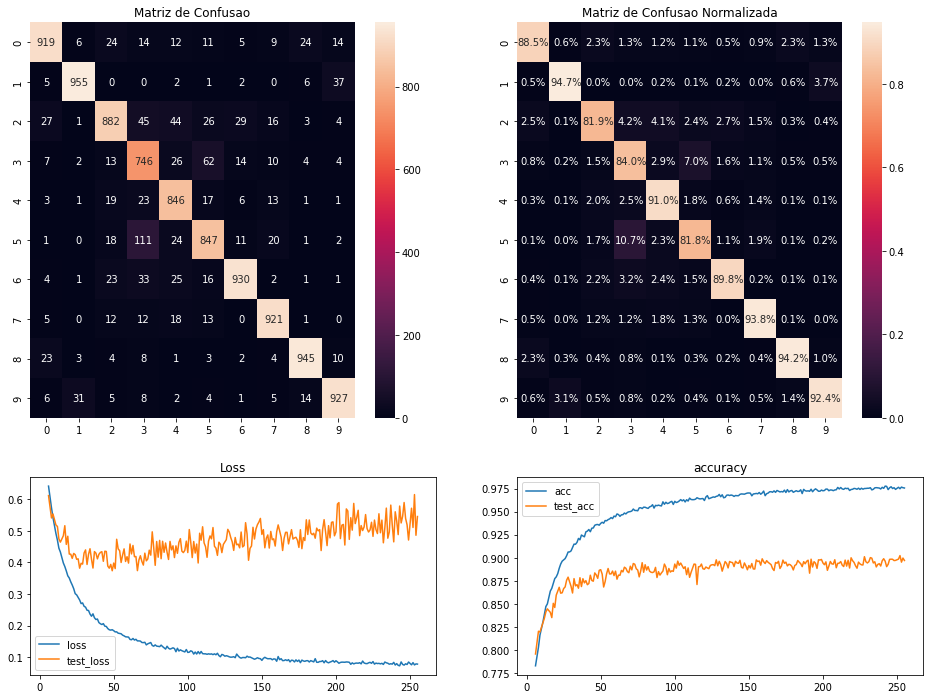

In [199]:
print("\n\nAcurácia balanceada:", balanced_acc, "\n")

fig, axs = plt.subplots(2, 2, figsize = (16,12), gridspec_kw={'height_ratios': [2, 1]})

#ax[0,0]
sns.heatmap(ax = axs[0, 0], data = cm, fmt='g', annot = True)
axs[0, 0].set_title('Matriz de Confusao')
#ax[0,1]
sns.heatmap(ax = axs[0, 1], data =cm_b, fmt='.1%', annot = True)
axs[0, 1].set_title('Matriz de Confusao Normalizada')

#ax[1,0]
axs[1, 0].set_title('Loss')
axs[1, 0].plot(df_history_c['loss'], label='loss')
axs[1, 0].plot(df_history_c['val_loss'], label='test_loss')
axs[1, 0].legend()

axs[1, 1].set_title('accuracy')
axs[1, 1].plot(df_history_c['accuracy'], label='acc')
axs[1, 1].plot(df_history_c['val_accuracy'], label='test_acc')
axs[1, 1].legend()  


In [ ]:
    fig, axs = plt.subplots(2, 2, figsize = (16,12), gridspec_kw={'height_ratios': [2, 1]})

    #ax[0,0]
    sns.heatmap(ax = axs[0, 0], data = cm, fmt='g', annot = True)
    axs[0, 0].set_title('Matriz de Confusao')
    #ax[0,1]
    sns.heatmap(ax = axs[0, 1], data =cm_b, fmt='.1%', annot = True)
    axs[0, 1].set_title('Matriz de Confusao Normalizada')

    #ax[1,0]
    axs[1, 0].set_title('Loss')
    axs[1, 0].plot(model_history.history['loss'], label='loss')
    axs[1, 0].plot(model_history.history['val_loss'], label='val_loss')
    axs[1, 0].legend()

    axs[1, 1].set_title('accuracy')
    axs[1, 1].plot(model_history.history['accuracy'], label='acc')
    axs[1, 1].plot(model_history.history['val_accuracy'], label='val_acc')
    axs[1, 1].legend()  


# 9. (2,0) Sumarize os seus resultados e conclusões em relação aos resultados experimentais.